In [117]:
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from skopt import gp_minimize
import skopt
from skopt import dump, load

# Data Analysis for Water Quality

In [128]:
df = pd.read_csv('star_class.csv')
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [129]:
df.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

In [130]:
spectral_dummies = pd.get_dummies(df['Spectral Class'])
sc_dummies = pd.get_dummies(df['Star color'])
df = df.drop(columns=['Star color', 'Spectral Class'], axis=1).join(spectral_dummies).join(sc_dummies)
df.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star type', 'A', 'B', 'F', 'G', 'K', 'M',
       'O', 'Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ',
       'Blue-White', 'Blue-white', 'Orange', 'Orange-Red',
       'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish',
       'Yellowish', 'Yellowish White', 'white', 'yellow-white', 'yellowish'],
      dtype='object')

In [235]:
st_mapper = {
    0: 'Brown Dwarf',
    1: 'Red Dwarf',
    2: 'White Dwarf',
    3: 'Main Sequence', 
    4: 'SuperGiants',
    5: 'HyperGiants',
}
y_mapped = df['Star type'].apply(lambda x: st_mapper[x]).to_numpy()

### Class Imbalance

[Text(0.5, 1.0, 'Class Imbalance for Star Type')]

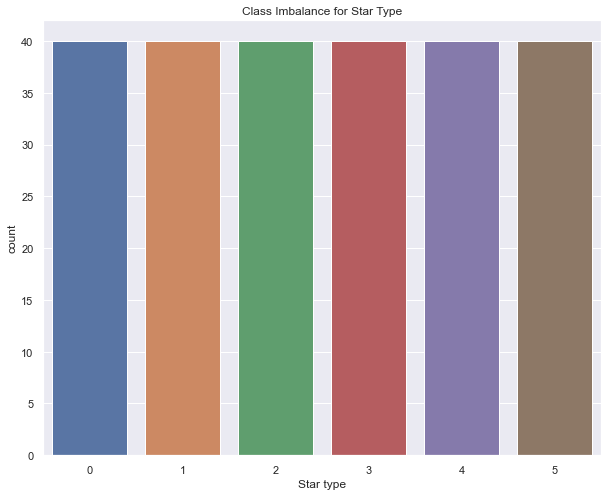

In [236]:
count_plot = sns.countplot(df['Star type'], label='Count')
count_plot.set(title='Class Imbalance for Star Type')

[Text(0.5, 1.0, 'Correlation of Star Type Features')]

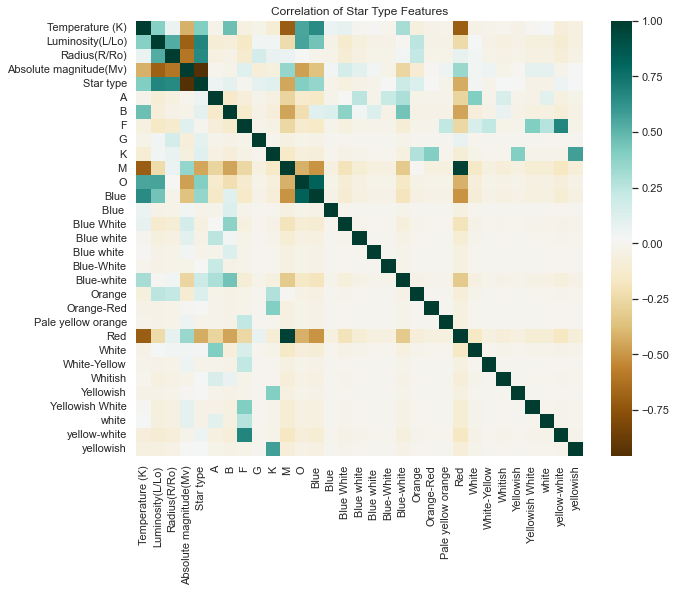

In [228]:
hm = sns.heatmap(df.corr(), cmap='BrBG')
hm.set(title='Correlation of Star Type Features')

# Data Pre-Processing

In [31]:
x_pre = df.drop(columns=['Star type'], axis=1).to_numpy()
y = df['Star type'].to_numpy()
x = StandardScaler().fit_transform(x_pre)

# Baseline Model

In [41]:
x.shape

(240, 30)

In [122]:
x_train_base, x_test_base, y_train_base, y_test_base = train_test_split(x, y, test_size=.2, random_state=0)

In [189]:
base_mlp = MLPClassifier(max_iter=100)
param_space = {
    'hidden_layer_sizes': [(25, 10), (20, 15), (15, 8), (23, 13), (10, 8)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'adaptive']
}
base_clf = GridSearchCV(base_mlp, param_space, n_jobs=-1, cv=5)
base_clf.fit(x_train_base, y_train_base)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(25, 10), (20, 15), (15, 8),
                                                (23, 13), (10, 8)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

### Results

In [190]:
print(f'Best Parameters: \n{base_clf.best_params_}')

Best Parameters: 
{'activation': 'tanh', 'hidden_layer_sizes': (23, 13), 'learning_rate': 'constant', 'solver': 'adam'}


In [191]:
print(classification_report(base_clf.predict(x_test_base), y_test_base))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70        13
           1       0.33      1.00      0.50         3
           2       0.71      1.00      0.83         5
           3       0.88      1.00      0.93         7
           4       0.82      0.90      0.86        10
           5       0.83      0.50      0.62        10

    accuracy                           0.75        48
   macro avg       0.76      0.82      0.74        48
weighted avg       0.84      0.75      0.75        48



# PCA

In [192]:
pca = PCA(n_components=15)
pca_results = pca.fit_transform(x)
print(f'Exp. Variation per PC: {pca.explained_variance_ratio_}')

Exp. Variation per PC: [0.14293766 0.08866871 0.06771866 0.06538462 0.05815454 0.05159732
 0.03698113 0.03467908 0.03415982 0.03393411 0.03380543 0.03375206
 0.03370797 0.0335677  0.0335429 ]


[Text(0.5, 1.0, 'PCA Biplot for Star Classification')]

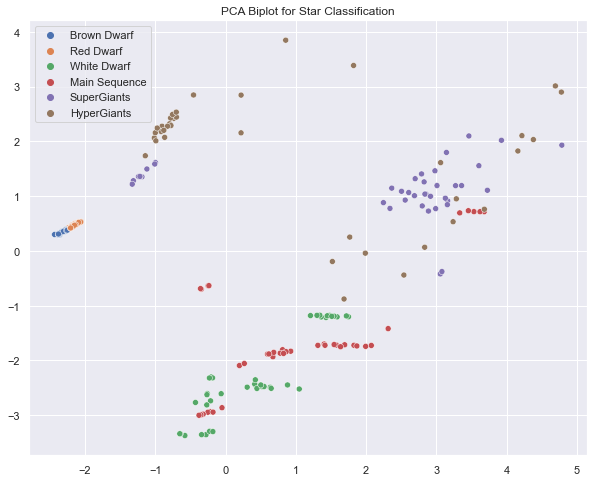

In [237]:
pca_one, pca_two = pca_results[:,0], pca_results[:,1]
pca_biplot = sns.scatterplot(x=pca_one, y=pca_two, hue=y_mapped)
pca_biplot.set(title='PCA Biplot for Star Classification')

# t-SNE

In [256]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(x)
tsne_one, tsne_two = tsne_results[:,0], tsne_results[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.000s...
[t-SNE] Computed neighbors for 240 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 0.226916
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.469032
[t-SNE] KL divergence after 300 iterations: 0.173107


[Text(0.5, 1.0, 't-SNE for Star Types Perplexity 30')]

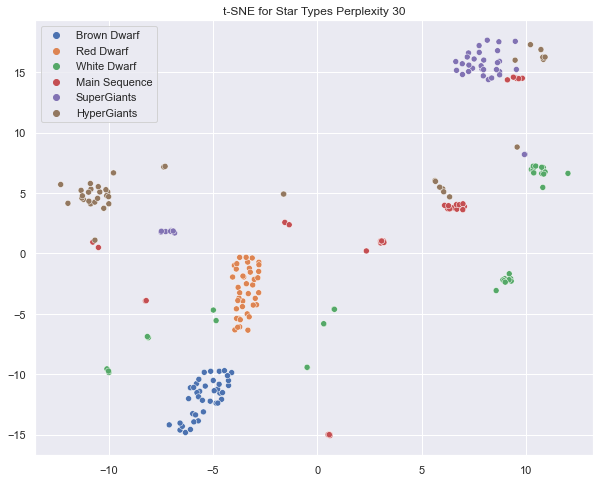

In [257]:
tsne_plot = sns.scatterplot(x=tsne_one, y=tsne_two, hue=y_mapped)
tsne_plot.set(title='t-SNE for Star Types Perplexity 30')

# UMAP

In [196]:
umap_results = umap.UMAP().fit_transform(x)
umap_one, umap_two = umap_results[:,0], umap_results[:,1]

[Text(0.5, 1.0, 'UMAP for Star Types')]

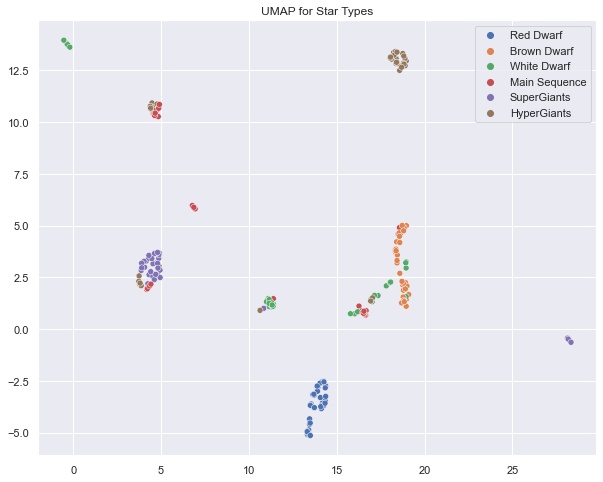

In [197]:
umap_plot = sns.scatterplot(x=umap_one, y=umap_two, hue=y_mapped)
umap_plot.set(title='UMAP for Star Types')

# Filter Method w/ Chi-Square

In [198]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

In [199]:
x_min_scaled = MinMaxScaler().fit_transform(x_pre)
x_train, x_test, y_train, y_test = train_test_split(x_min_scaled, y, test_size=.2, random_state=0)

[Text(0.5, 1.0, 'Chi2 Scores'),
 Text(0.5, 0, 'Feature Number'),
 Text(0, 0.5, 'Chi2 Score')]

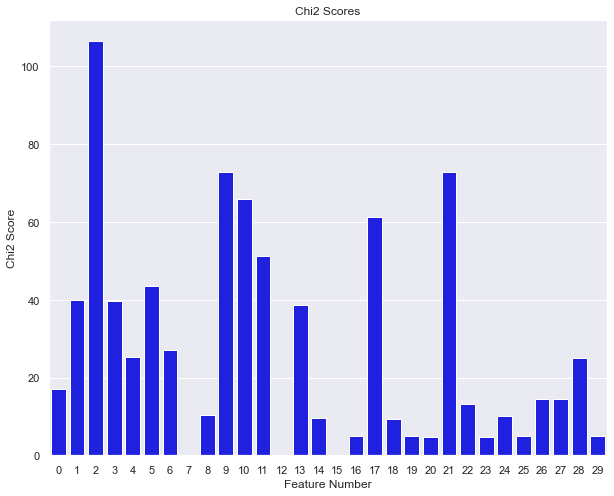

In [264]:
sns.set(rc={'figure.figsize': (10,8)})
chi = SelectKBest(chi2, k=20)
x_train_chi = chi.fit_transform(x_train, y_train)
chi_plot = sns.barplot(x=np.arange(0, 30), y=chi.scores_, color='blue')
chi_plot.set(title='Chi2 Scores', xlabel='Feature Number', ylabel='Chi2 Score')

In [265]:
chi_mlp = MLPClassifier(max_iter=100)
chi_clf = GridSearchCV(chi_mlp, param_space, n_jobs=-1, cv=5)
chi_clf.fit(x_train_chi, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(25, 10), (20, 15), (15, 8),
                                                (23, 13), (10, 8)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [266]:
print(f'Best parameters found:\n{chi_clf.best_params_}')
print(classification_report(chi_clf.predict(chi.transform(x_test)), y_test))

Best parameters found:
{'activation': 'tanh', 'hidden_layer_sizes': (23, 13), 'learning_rate': 'adaptive', 'solver': 'adam'}
              precision    recall  f1-score   support

           0       1.00      0.39      0.56        18
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       0.82      1.00      0.90         9
           5       1.00      1.00      1.00         6

    accuracy                           0.77        48
   macro avg       0.80      0.73      0.74        48
weighted avg       0.97      0.77      0.82        48



/Users/alecrospierski/opt/anaconda3/envs/tensors-are-fun/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/alecrospierski/opt/anaconda3/envs/tensors-are-fun/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/alecrospierski/opt/anaconda3/envs/tensors-are-fun/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/Users/alecrospierski/opt/anaconda3/envs/tensors-are-fun/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stoc

# Wrapper Method w/ Recursive Feature Elimination

In [215]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [216]:
# rfe_mlp = MLPClassifier(max_iter=100)
rfe_clf = RandomForestClassifier()
rfe_cv = RFECV(estimator=rfe_clf, step=1, cv=StratifiedKFold(5), scoring='accuracy')
rfe_cv = rfe_cv.fit(x_train, y_train)

In [218]:
print('Optimal Number of Features :', rfe_cv.n_features_, '\n')
print('Best Features :', df.drop(['Star type'], axis=1).columns[rfe_cv.support_], '\n')

Optimal Number of Features : 2 

Best Features : Index(['Radius(R/Ro)', 'Absolute magnitude(Mv)'], dtype='object') 



[Text(0.5, 1.0, 'CV Scores per # of Features'),
 Text(0.5, 0, 'Number of Features Selected'),
 Text(0, 0.5, 'CV Acc. Score')]

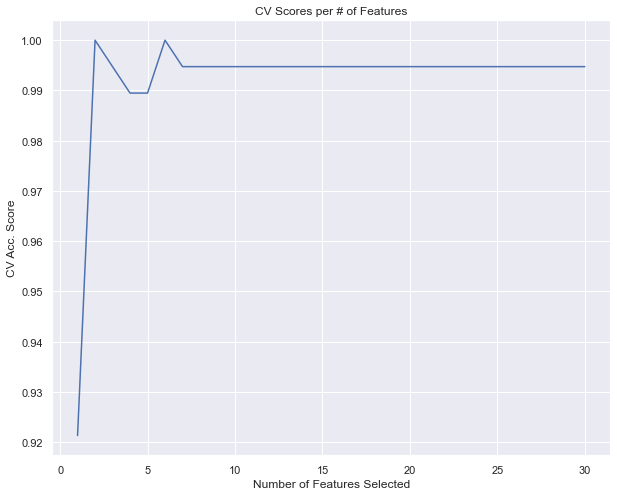

In [226]:
rfe_plot = sns.lineplot(x=range(1, len(rfe_cv.grid_scores_) + 1), y=np.array([ np.mean(x) for x in rfe_cv.grid_scores_ ]))
rfe_plot.set(title='CV Scores per # of Features', xlabel='Number of Features Selected', ylabel='CV Acc. Score')

In [227]:
print(classification_report(y_test, rfe_cv.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         6

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



# Baseline RandomForest Model

In [268]:
cv = StratifiedKFold(5)
val_scores = []
for tr, vl in cv.split(x_train, y_train):
    base_rf_clf = RandomForestClassifier()
    x_tr, x_vl, y_tr, y_vl = x_train[tr], x_train[vl], y_train[tr], y_train[vl]
    
    base_rf_clf.fit(x_tr, y_tr)
    val_scores.append(accuracy_score(base_rf_clf.predict(x_vl), y_vl))
np.mean(val_scores)

0.9947368421052631

In [270]:
base_rf_clf = RandomForestClassifier()
base_rf_clf.fit(x_train, y_train)
accuracy_score(base_rf_clf.predict(x_test), y_test)

1.0